In [ ]:
!pip install roboflow
!pip install ultralytics
!pip install albumentations
!pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.1 MB/s eta 0:00:00


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="9XL0nVDKDrp1JBpkTXwh")
project = rf.workspace("tt-mvdxi").project("2classes-real-with-augmentation")
version = project.version(3)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 2classes-real-with-augmentation-3 in yolov8:: 100%|██████████| 4552/4552 [00:00<00:00, 12526.28it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
dataset.location

'/content/2classes-real-with-augmentation-3'

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="9XL0nVDKDrp1JBpkTXwh")
project = rf.workspace("caise").project("cavity-qhuov")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cavity-1 in yolov8:: 100%|██████████| 1216/1216 [00:00<00:00, 6836.15it/s]


In [ ]:
dataset.location

'/content/cavity-1'

In [ ]:
import os
import shutil
from glob import glob
import random
import yaml

# -----------------------
# Paths to datasets
# -----------------------
full_mouth_path = "/content/cavity-1"  # only 'decayCavity'
single_tooth_path = "/content/2classes-real-with-augmentation-3"  # 'decayCavity', 'earlyCavity'

# -----------------------
# Combined dataset path
# -----------------------
combined_path = "/content/combined_dataset"
train_img_path = os.path.join(combined_path, "train/images")
train_lbl_path = os.path.join(combined_path, "train/labels")
val_img_path = os.path.join(combined_path, "val/images")
val_lbl_path = os.path.join(combined_path, "val/labels")

# Create folders
for p in [train_img_path, train_lbl_path, val_img_path, val_lbl_path]:
    os.makedirs(p, exist_ok=True)

# -----------------------
# Helper function to copy images + labels
# -----------------------
def copy_yolo_data(src_path, label_map, split_ratio=0.8):
    img_files = glob(os.path.join(src_path, "train/images/*.*")) + glob(os.path.join(src_path, "valid/images/*.*"))
    lbl_files = [f.replace("images", "labels").rsplit(".",1)[0]+".txt" for f in img_files]

    combined = list(zip(img_files, lbl_files))
    random.shuffle(combined)

    split_idx = int(len(combined) * split_ratio)

    train_set = combined[:split_idx]
    val_set = combined[split_idx:]

    for img_f, lbl_f in train_set:
        # copy image
        shutil.copy(img_f, train_img_path)
        # copy label and remap classes
        if os.path.exists(lbl_f):
            with open(lbl_f, "r") as f:
                lines = f.readlines()
            new_lines = []
            for line in lines:
                parts = line.strip().split()
                cls_id = int(parts[0])
                if cls_id in label_map:
                    parts[0] = str(label_map[cls_id])
                    new_lines.append(" ".join(parts))
            with open(os.path.join(train_lbl_path, os.path.basename(lbl_f)), "w") as f:
                f.write("\n".join(new_lines))

    for img_f, lbl_f in val_set:
        shutil.copy(img_f, val_img_path)
        if os.path.exists(lbl_f):
            with open(lbl_f, "r") as f:
                lines = f.readlines()
            new_lines = []
            for line in lines:
                parts = line.strip().split()
                cls_id = int(parts[0])
                if cls_id in label_map:
                    parts[0] = str(label_map[cls_id])
                    new_lines.append(" ".join(parts))
            with open(os.path.join(val_lbl_path, os.path.basename(lbl_f)), "w") as f:
                f.write("\n".join(new_lines))

# -----------------------
# Copy datasets
# -----------------------
# Full mouth dataset: all 'decayCavity' → class 0
copy_yolo_data(full_mouth_path, label_map={0:0})

# Single tooth dataset: 0=decayCavity, 1=earlyCavity
copy_yolo_data(single_tooth_path, label_map={0:0, 1:1})

# -----------------------
# Create combined data.yaml
# -----------------------
data_yaml = {
    'train': os.path.join(combined_path, 'train/images'),
    'val': os.path.join(combined_path, 'val/images'),
    'nc': 2,
    'names': ['decayCavity', 'earlyCavity']
}

with open(os.path.join(combined_path, 'data_combined.yaml'), 'w') as f:
    yaml.dump(data_yaml, f)

print("Combined dataset ready at", combined_path)
print("data_combined.yaml created!")



Combined dataset ready at /content/combined_dataset
data_combined.yaml created!


In [ ]:
!yolo detect train data=/content/combined_dataset/data_combined.yaml model=yolov8m.pt imgsz=640 epochs=50 batch=16 name=combined_train


Ultralytics 8.3.217 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/combined_dataset/data_combined.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=combined_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

Model loaded: /content/runs/detect/combined_train/weights/best.pt


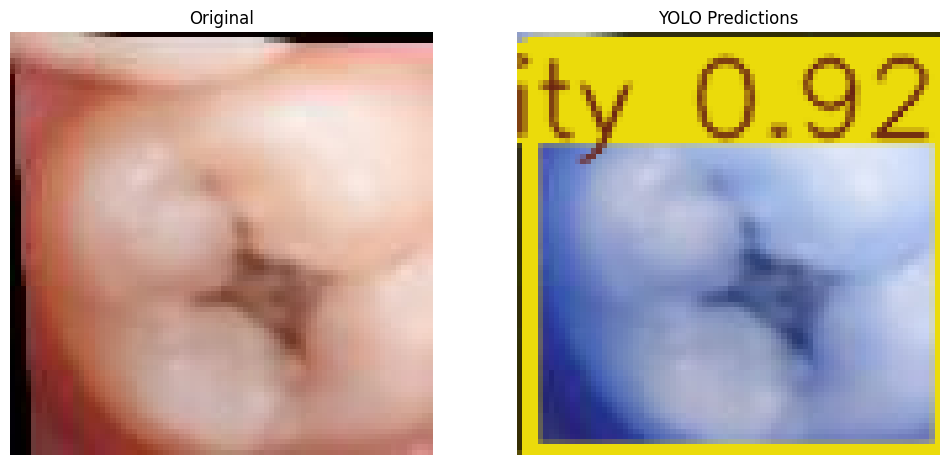

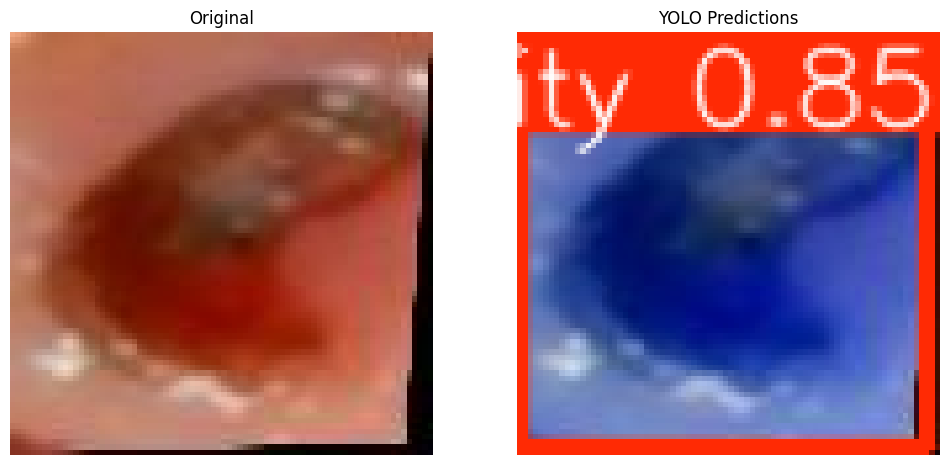

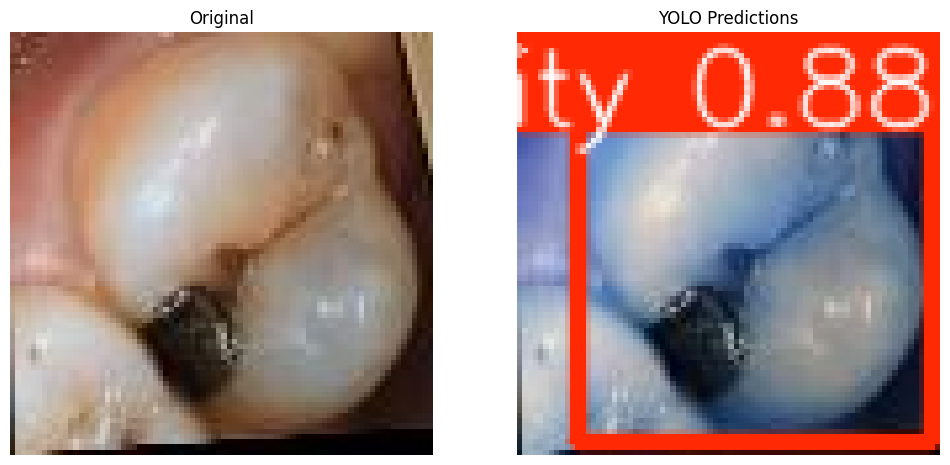

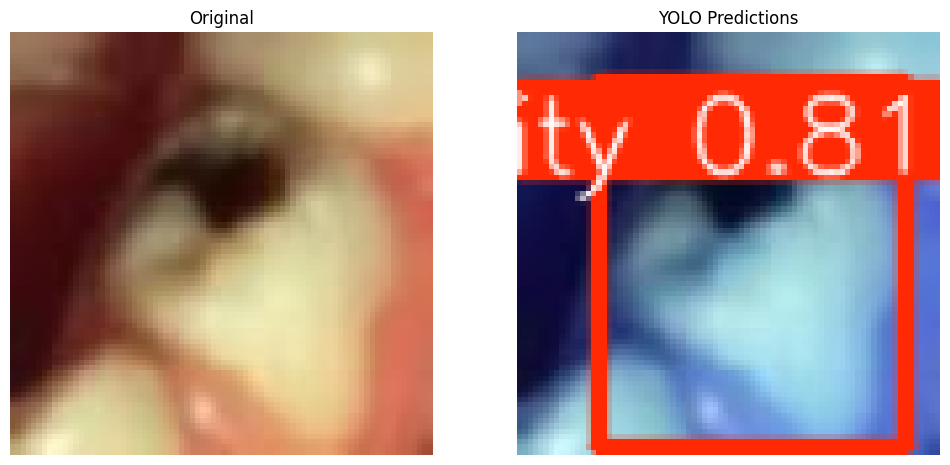

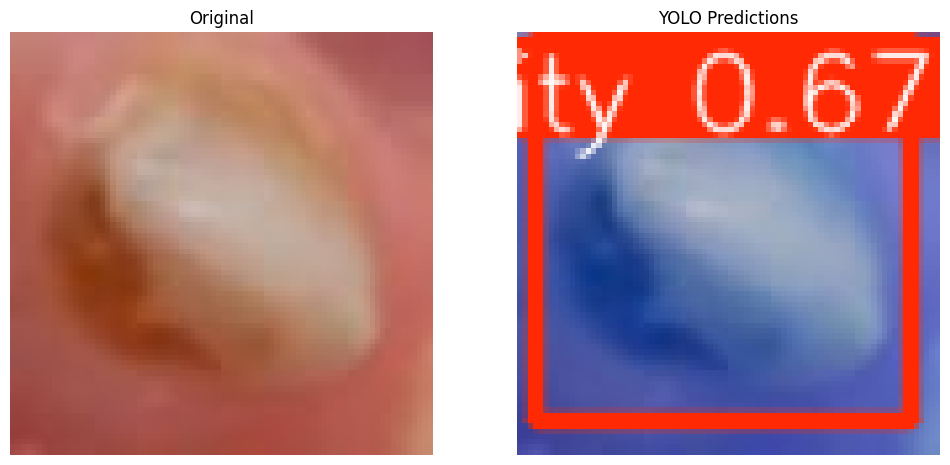

In [ ]:
# Colab-ready: visualize YOLO predictions vs original images

!pip install ultralytics --quiet

from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob
import random

# -----------------------------
# Load trained model
# -----------------------------
model_path = "/content/runs/detect/combined_train/weights/best.pt"  # adjust path
model = YOLO(model_path)
print("Model loaded:", model_path)

# -----------------------------
# Dataset folder to visualize
# -----------------------------
img_folder = "/content/combined_dataset/val/images"  # or any folder
img_files = glob(os.path.join(img_folder, "*.*"))
sample_files = random.sample(img_files, min(5, len(img_files)))  # show 5 random images

# -----------------------------
# Predict and display
# -----------------------------
for img_path in sample_files:
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # YOLO prediction
    results = model.predict(img, imgsz=640, conf=0.25, verbose=False)
    pred_img = results[0].plot()  # returns an image with boxes

    # Plot side-by-side
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(pred_img)
    plt.title("YOLO Predictions")
    plt.axis('off')

    plt.show()


Model loaded: /content/runs/detect/combined_train/weights/best.pt


Saving full mouth.jpg to full mouth.jpg
Uploaded: full mouth.jpg


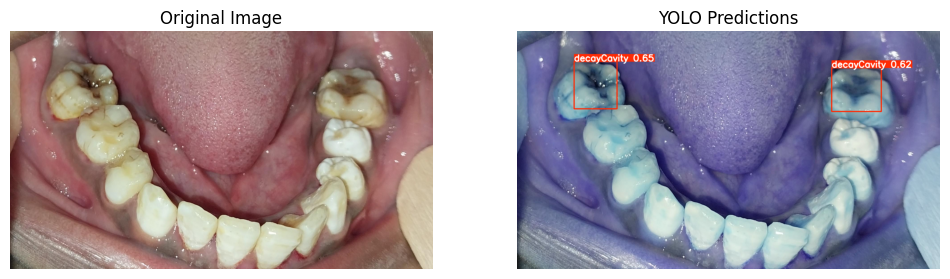

In [ ]:
!pip install ultralytics --quiet

from ultralytics import YOLO
import cv2
from google.colab import files
import matplotlib.pyplot as plt

# -----------------------------
# Load trained model
# -----------------------------
model_path = "/content/runs/detect/combined_train/weights/best.pt"  # adjust if needed
model = YOLO(model_path)
print("Model loaded:", model_path)

# -----------------------------
# Upload image
# -----------------------------
uploaded = files.upload()
for filename in uploaded.keys():
    img_path = filename
print("Uploaded:", img_path)

# -----------------------------
# Read image
# -----------------------------
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# -----------------------------
# Run YOLO prediction
# -----------------------------
results = model.predict(img, imgsz=640, conf=0.25, verbose=False)
pred_img = results[0].plot()  # draw bounding boxes

# -----------------------------
# Display original vs prediction
# -----------------------------
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(pred_img)
plt.title("YOLO Predictions")
plt.axis('off')
plt.show()


Model loaded: /content/runs/detect/combined_train/weights/best.pt


Saving cav.jpg to cav.jpg
Uploaded: cav.jpg


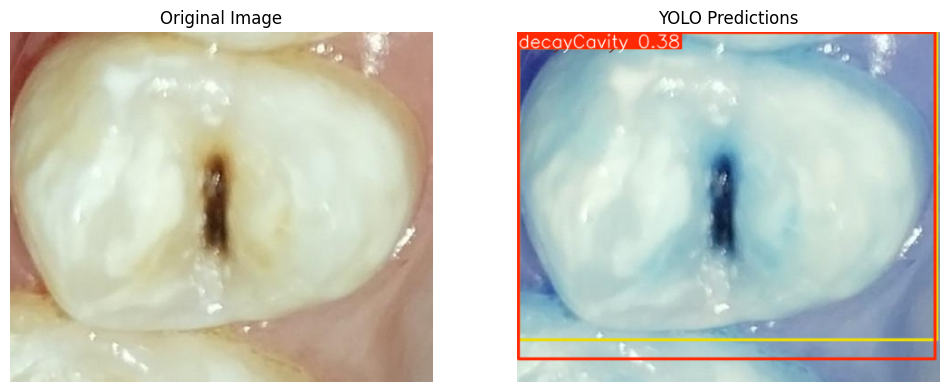

In [ ]:
!pip install ultralytics --quiet

from ultralytics import YOLO
import cv2
from google.colab import files
import matplotlib.pyplot as plt

# -----------------------------
# Load trained model
# -----------------------------
model_path = "/content/runs/detect/combined_train/weights/best.pt"  # adjust if needed
model = YOLO(model_path)
print("Model loaded:", model_path)

# -----------------------------
# Upload image
# -----------------------------
uploaded = files.upload()
for filename in uploaded.keys():
    img_path = filename
print("Uploaded:", img_path)

# -----------------------------
# Read image
# -----------------------------
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# -----------------------------
# Run YOLO prediction
# -----------------------------
results = model.predict(img, imgsz=640, conf=0.25, verbose=False)
pred_img = results[0].plot()  # draw bounding boxes

# -----------------------------
# Display original vs prediction
# -----------------------------
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(pred_img)
plt.title("YOLO Predictions")
plt.axis('off')
plt.show()


Model loaded: /content/runs/detect/combined_train/weights/best.pt


Saving single no cav.jpg to single no cav.jpg
Uploaded: single no cav.jpg


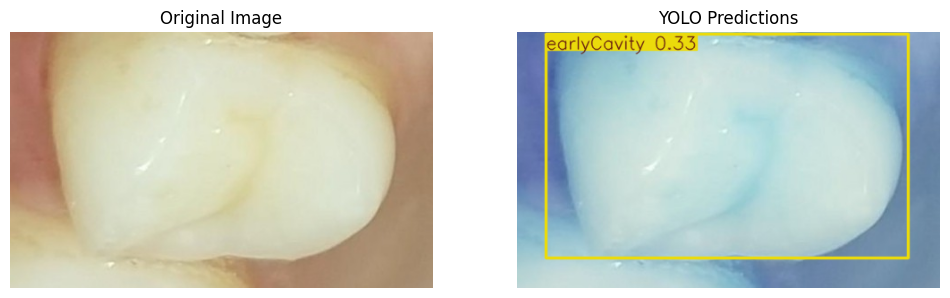

In [ ]:
!pip install ultralytics --quiet

from ultralytics import YOLO
import cv2
from google.colab import files
import matplotlib.pyplot as plt

# -----------------------------
# Load trained model
# -----------------------------
model_path = "/content/runs/detect/combined_train/weights/best.pt"  # adjust if needed
model = YOLO(model_path)
print("Model loaded:", model_path)

# -----------------------------
# Upload image
# -----------------------------
uploaded = files.upload()
for filename in uploaded.keys():
    img_path = filename
print("Uploaded:", img_path)

# -----------------------------
# Read image
# -----------------------------
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# -----------------------------
# Run YOLO prediction
# -----------------------------
results = model.predict(img, imgsz=640, conf=0.25, verbose=False)
pred_img = results[0].plot()  # draw bounding boxes

# -----------------------------
# Display original vs prediction
# -----------------------------
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(pred_img)
plt.title("YOLO Predictions")
plt.axis('off')
plt.show()



Model loaded: /content/runs/detect/combined_train/weights/best.pt


Saving full mouth 2.jpg to full mouth 2.jpg
Uploaded: full mouth 2.jpg


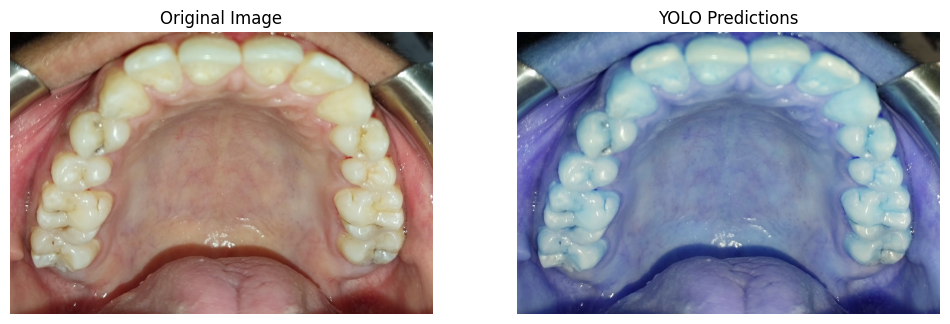

In [ ]:
!pip install ultralytics --quiet

from ultralytics import YOLO
import cv2
from google.colab import files
import matplotlib.pyplot as plt

# -----------------------------
# Load trained model
# -----------------------------
model_path = "/content/runs/detect/combined_train/weights/best.pt"  # adjust if needed
model = YOLO(model_path)
print("Model loaded:", model_path)

# -----------------------------
# Upload image
# -----------------------------
uploaded = files.upload()
for filename in uploaded.keys():
    img_path = filename
print("Uploaded:", img_path)

# -----------------------------
# Read image
# -----------------------------
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# -----------------------------
# Run YOLO prediction
# -----------------------------
results = model.predict(img, imgsz=640, conf=0.25, verbose=False)
pred_img = results[0].plot()  # draw bounding boxes

# -----------------------------
# Display original vs prediction
# -----------------------------
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(pred_img)
plt.title("YOLO Predictions")
plt.axis('off')
plt.show()


In [ ]:
import os
import pandas as pd

base_run_folder = "/content/runs/detect"  # YOLO default

# List all subfolders
if os.path.exists(base_run_folder):
    subfolders = [os.path.join(base_run_folder, f) for f in os.listdir(base_run_folder)]
    subfolders = [f for f in subfolders if os.path.isdir(f)]

    if len(subfolders) == 0:
        print("No runs found in", base_run_folder)
    else:
        # Pick the latest run
        latest_run = max(subfolders, key=os.path.getmtime)
        print("Latest run folder:", latest_run)

        # Path to results.csv
        results_csv = os.path.join(latest_run, "results.csv")
        if os.path.exists(results_csv):
            df = pd.read_csv(results_csv)
            print("Training metrics:")
            display(df)
        else:
            print("results.csv not found in:", latest_run)
else:
    print("Base run folder does not exist:", base_run_folder)


Latest run folder: /content/runs/detect/combined_train
Training metrics:


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,83.1245,1.07759,1.63439,1.56911,0.27173,0.42059,0.30407,0.18371,1.46851,2.88280,2.55525,0.000552,0.000552,0.000552
1,2,168.9670,1.13137,1.29773,1.60506,0.42224,0.70290,0.48594,0.27528,1.51915,1.87451,3.28405,0.001085,0.001085,0.001085
2,3,254.3120,1.09253,1.24720,1.57242,0.22301,0.53230,0.19119,0.07574,2.12607,2.85295,2.80691,0.001597,0.001597,0.001597
3,4,335.2170,1.05234,1.18126,1.53750,0.65736,0.68225,0.70381,0.46372,1.27254,1.22009,2.32689,0.001568,0.001568,0.001568
4,5,418.3830,1.03265,1.14733,1.53012,0.47553,0.70042,0.59758,0.39369,1.19560,1.37828,2.17041,0.001535,0.001535,0.001535
5,6,498.9510,0.98490,1.07101,1.48066,0.65964,0.81690,0.75019,0.53087,1.02892,0.98588,1.81089,0.001502,0.001502,0.001502
6,7,584.3440,0.95003,1.03155,1.45152,0.74084,0.80576,0.80072,0.54886,1.07278,0.98051,1.94815,0.001469,0.001469,0.001469
7,8,668.8880,0.93600,1.00653,1.43680,0.61148,0.81548,0.68927,0.48923,1.04872,1.04603,1.82418,0.001436,0.001436,0.001436
8,9,752.3950,0.89857,0.96545,1.39960,0.77074,0.79432,0.83707,0.60590,0.97386,0.92710,1.74759,0.001403,0.001403,0.001403
9,10,839.3780,0.87105,0.91025,1.38430,0.75880,0.84752,0.83592,0.60903,0.94164,0.81587,1.74628,0.001370,0.001370,0.001370


Latest run folder: /content/runs/detect/combined_train
Training metrics per epoch:


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,83.1245,1.07759,1.63439,1.56911,0.27173,0.42059,0.30407,0.18371,1.46851,2.88280,2.55525,0.000552,0.000552,0.000552
1,2,168.9670,1.13137,1.29773,1.60506,0.42224,0.70290,0.48594,0.27528,1.51915,1.87451,3.28405,0.001085,0.001085,0.001085
2,3,254.3120,1.09253,1.24720,1.57242,0.22301,0.53230,0.19119,0.07574,2.12607,2.85295,2.80691,0.001597,0.001597,0.001597
3,4,335.2170,1.05234,1.18126,1.53750,0.65736,0.68225,0.70381,0.46372,1.27254,1.22009,2.32689,0.001568,0.001568,0.001568
4,5,418.3830,1.03265,1.14733,1.53012,0.47553,0.70042,0.59758,0.39369,1.19560,1.37828,2.17041,0.001535,0.001535,0.001535
5,6,498.9510,0.98490,1.07101,1.48066,0.65964,0.81690,0.75019,0.53087,1.02892,0.98588,1.81089,0.001502,0.001502,0.001502
6,7,584.3440,0.95003,1.03155,1.45152,0.74084,0.80576,0.80072,0.54886,1.07278,0.98051,1.94815,0.001469,0.001469,0.001469
7,8,668.8880,0.93600,1.00653,1.43680,0.61148,0.81548,0.68927,0.48923,1.04872,1.04603,1.82418,0.001436,0.001436,0.001436
8,9,752.3950,0.89857,0.96545,1.39960,0.77074,0.79432,0.83707,0.60590,0.97386,0.92710,1.74759,0.001403,0.001403,0.001403
9,10,839.3780,0.87105,0.91025,1.38430,0.75880,0.84752,0.83592,0.60903,0.94164,0.81587,1.74628,0.001370,0.001370,0.001370


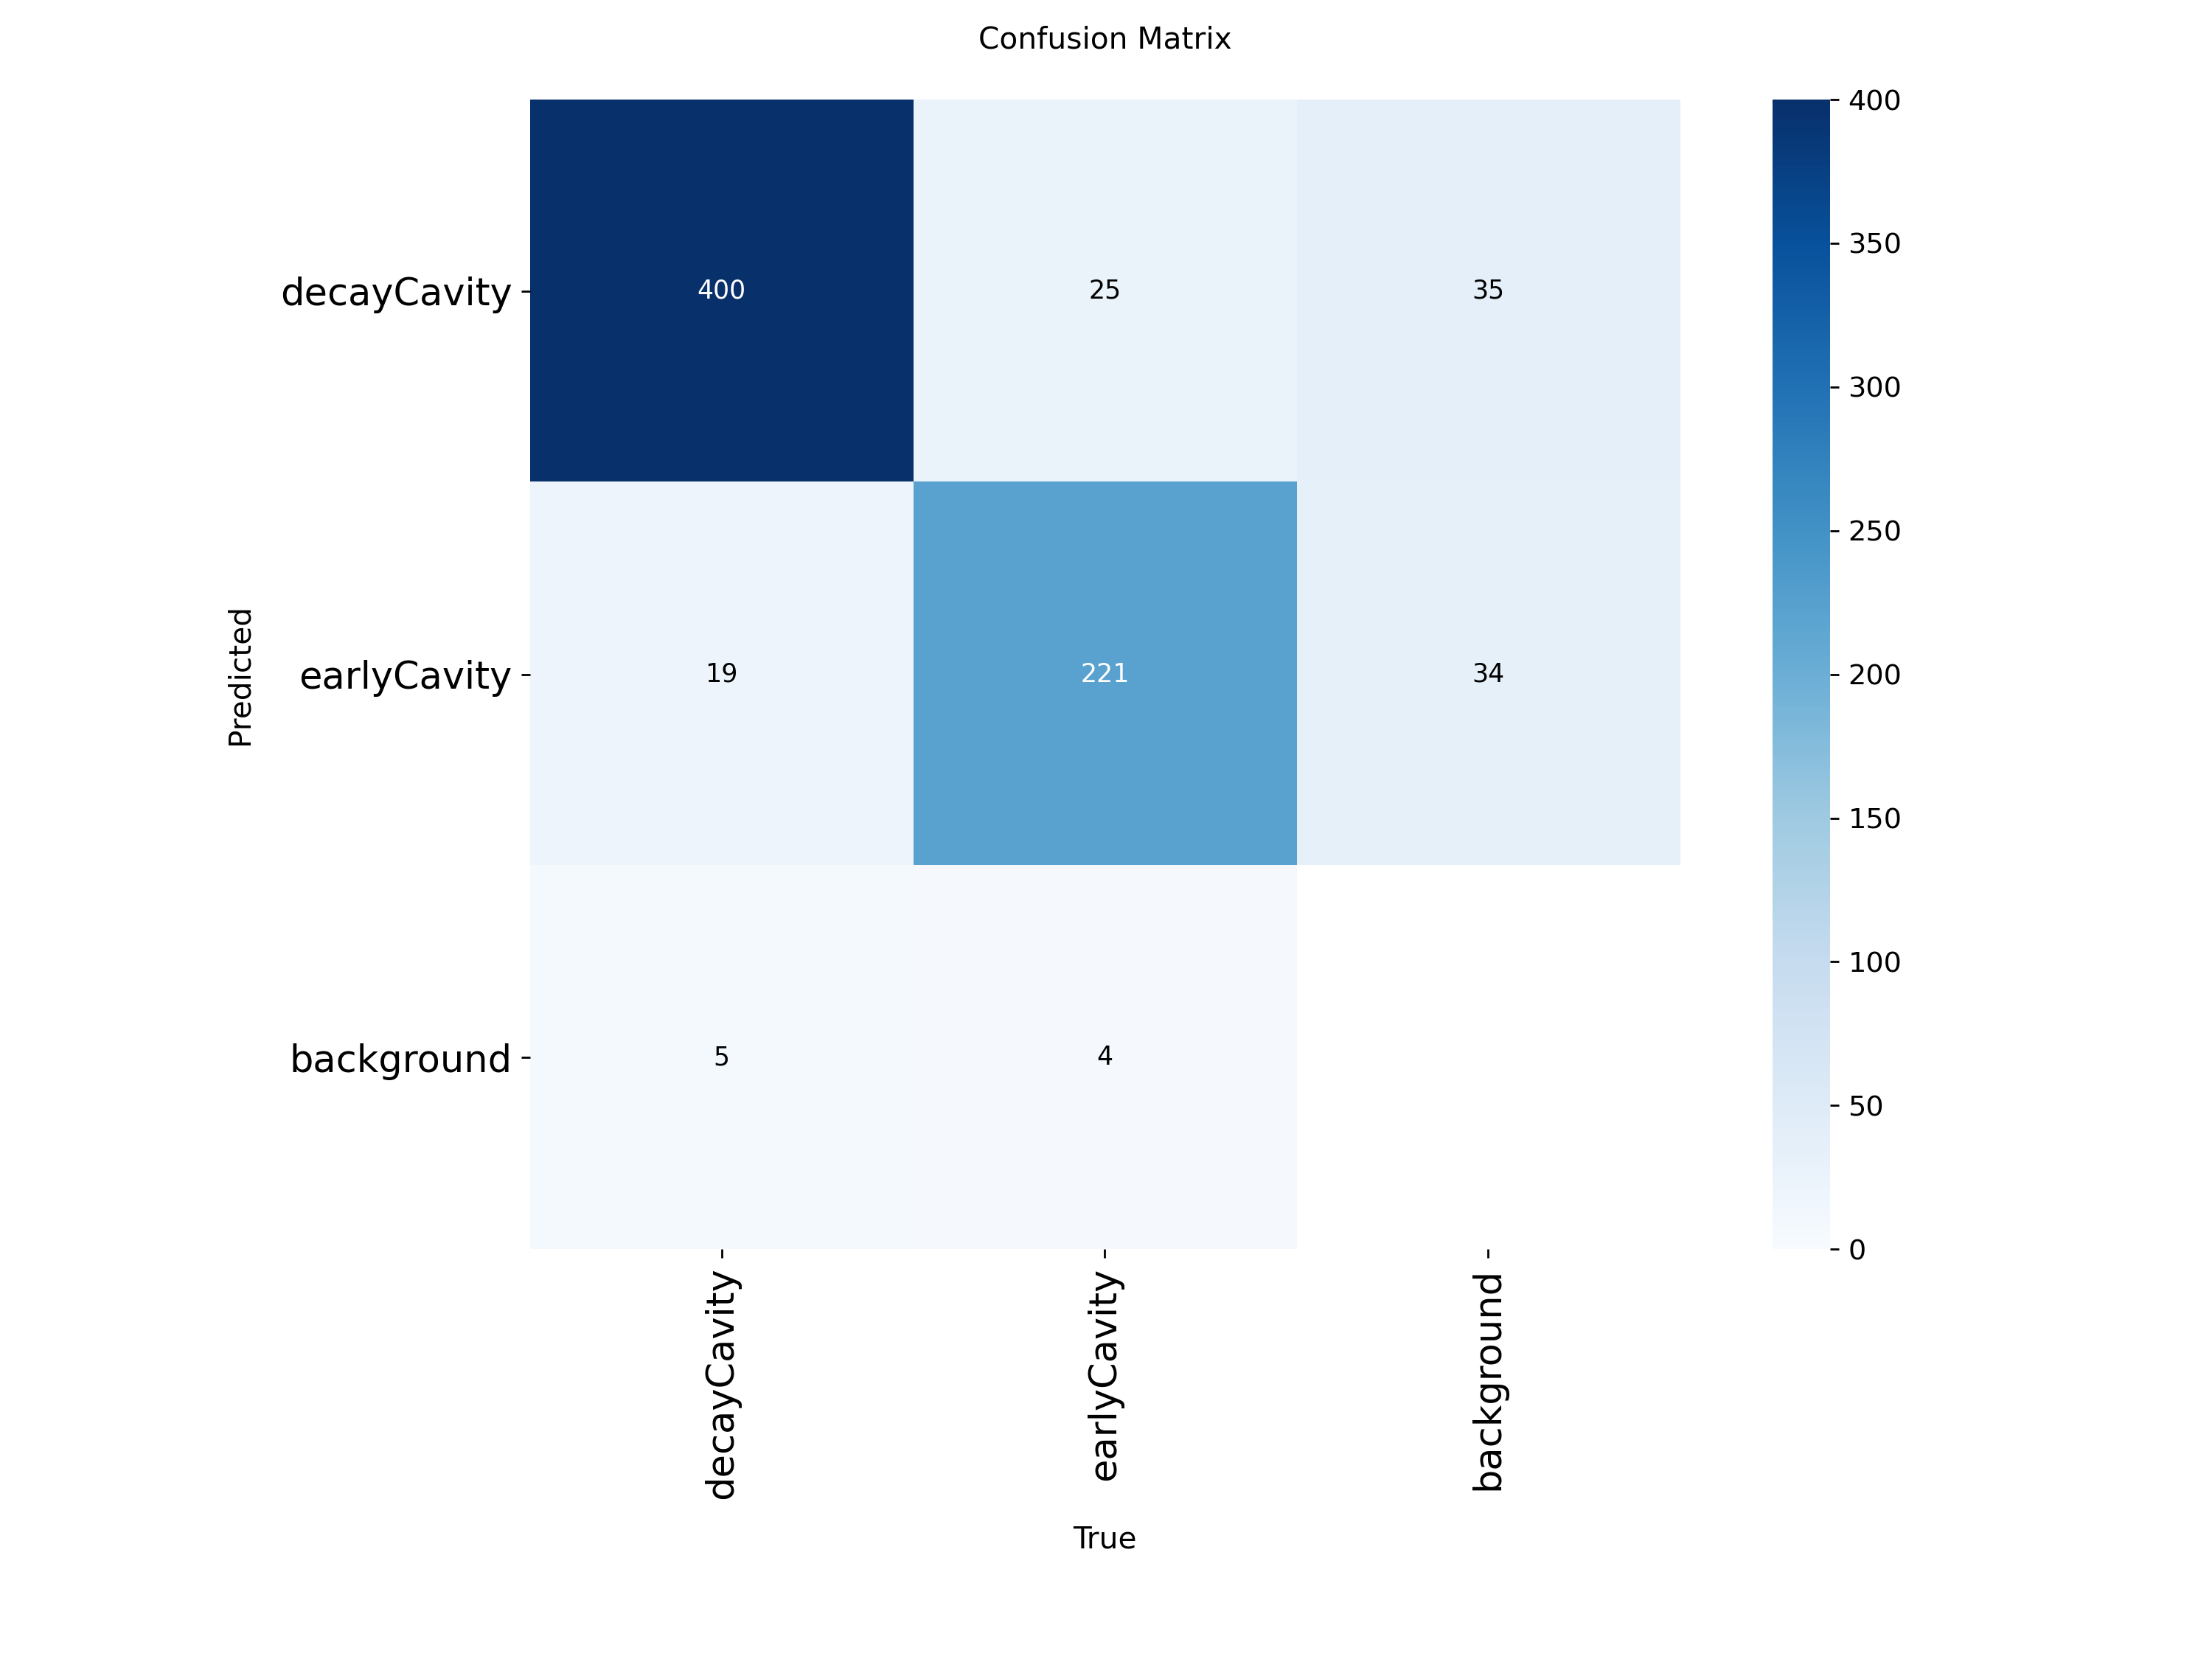

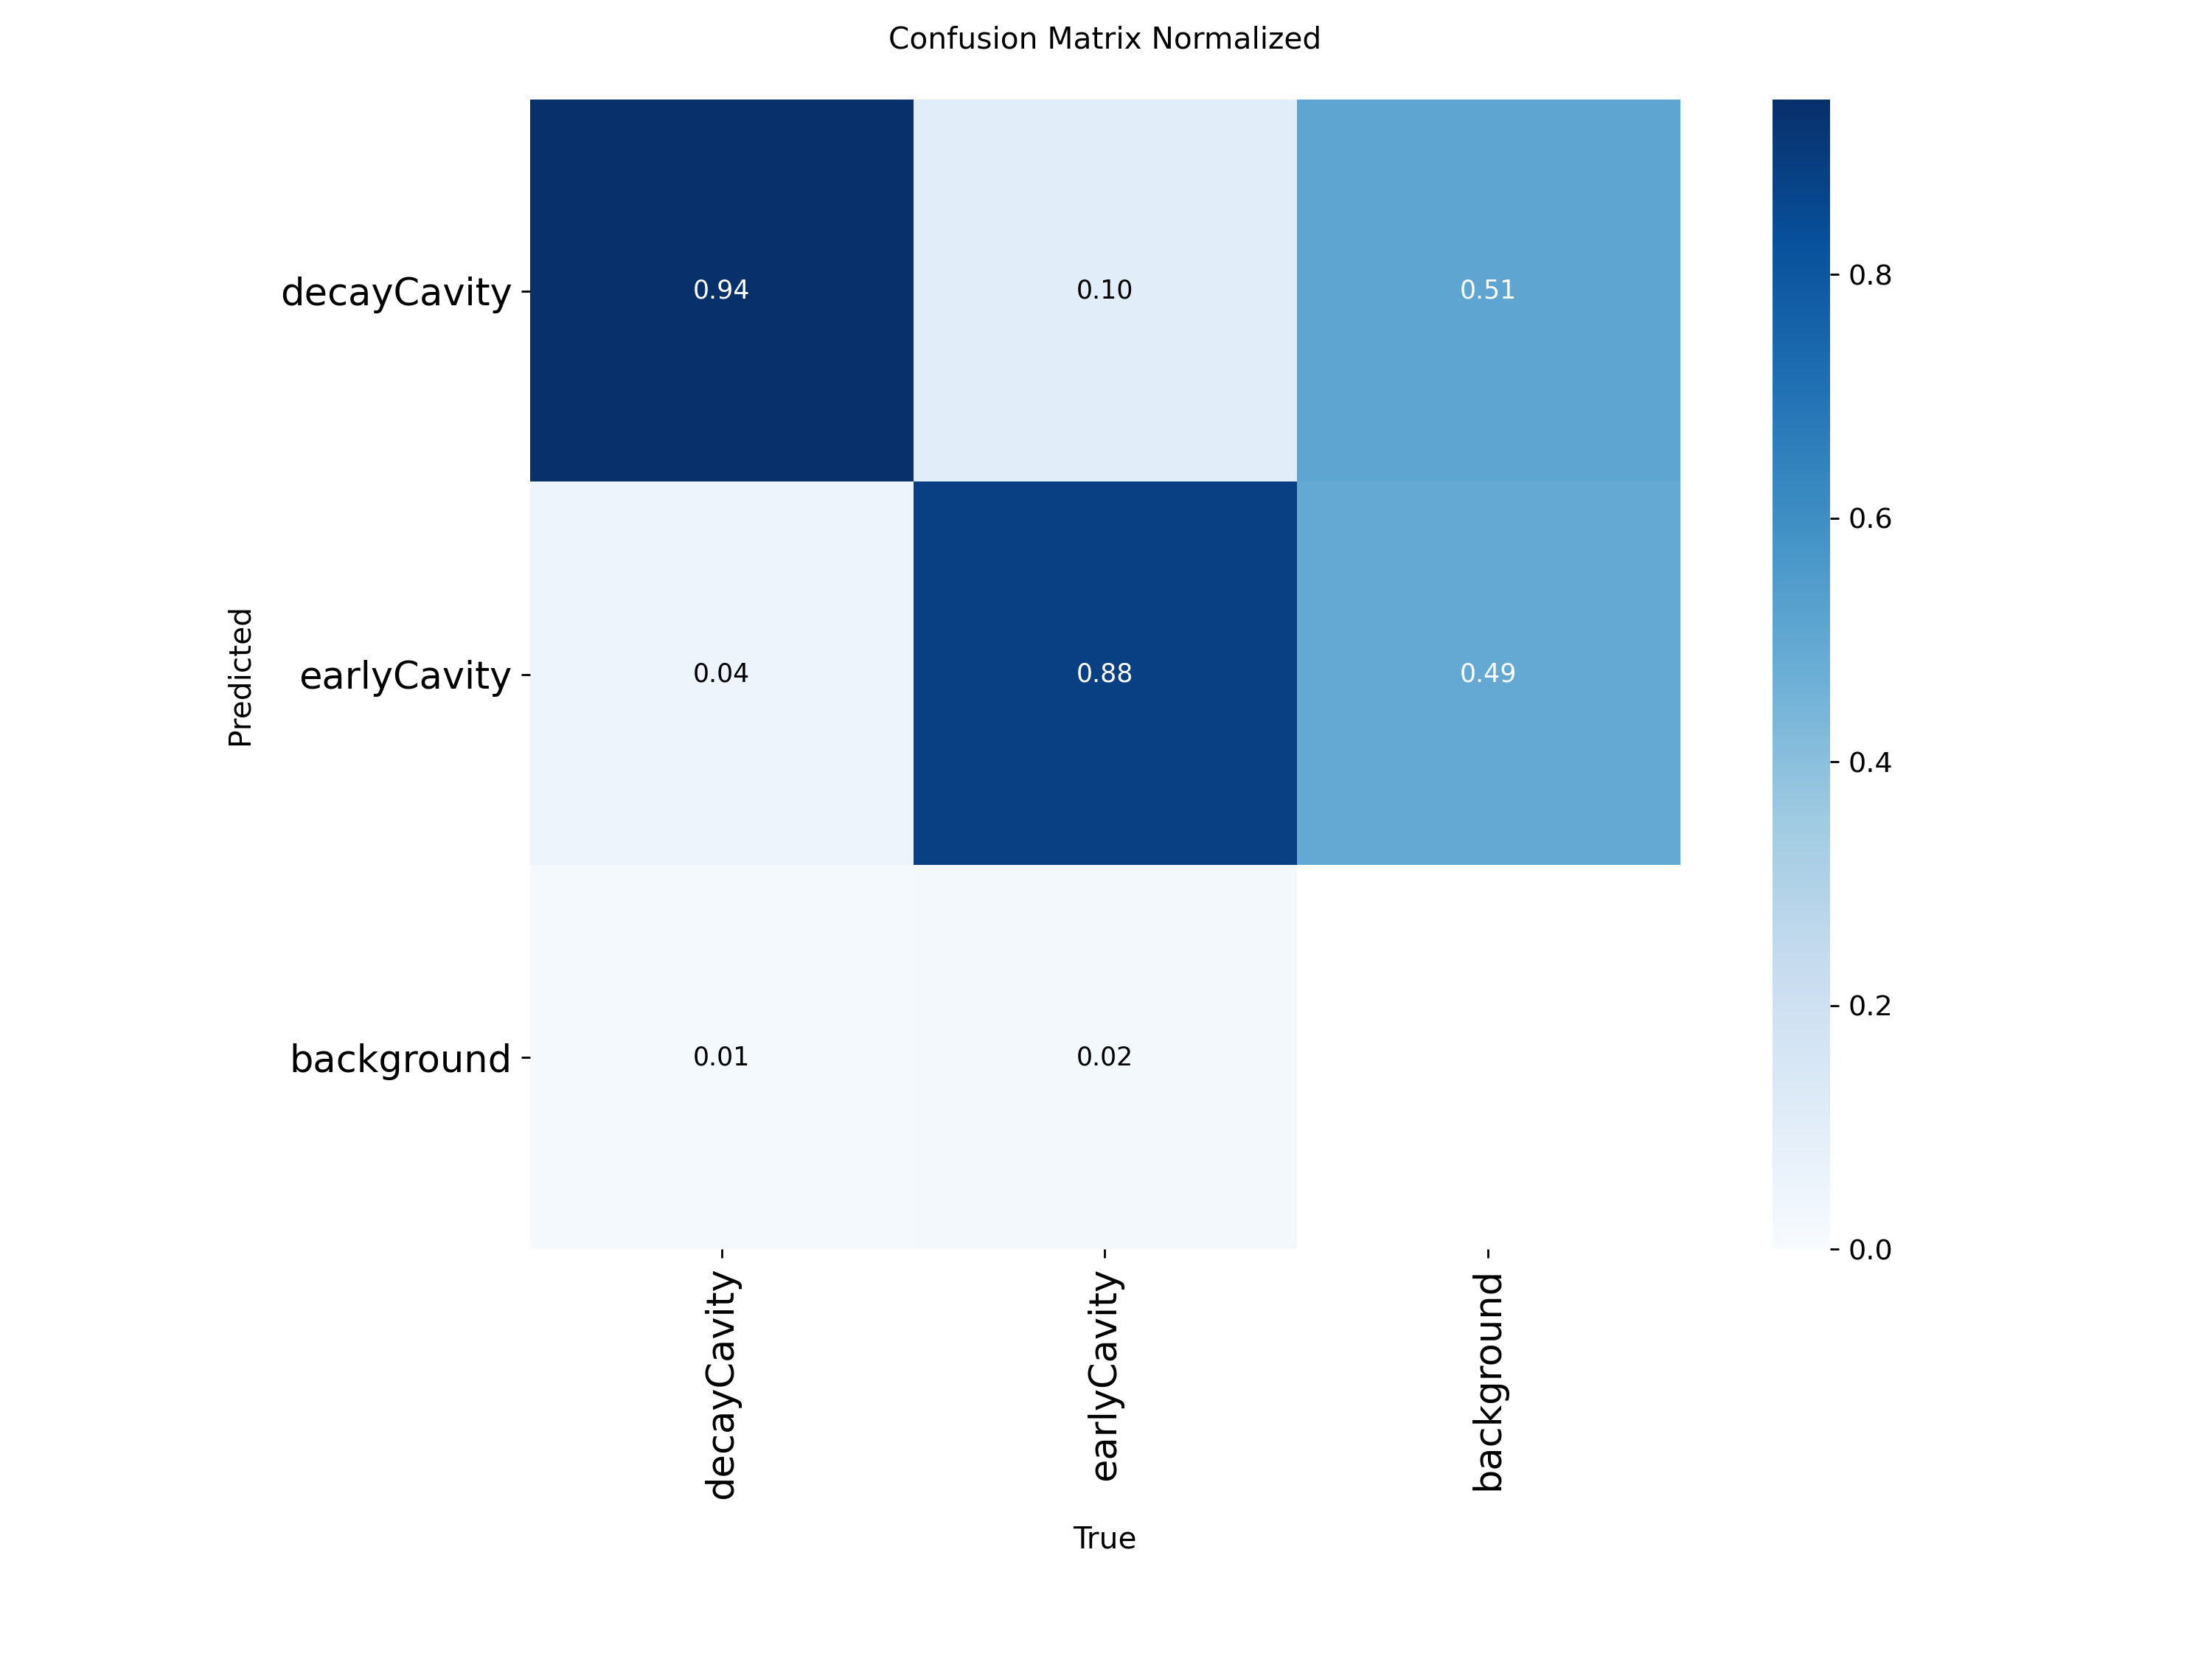

PR_curve.png not found in latest run folder
F1_curve.png not found in latest run folder
R_curve.png not found in latest run folder
P_curve.png not found in latest run folder


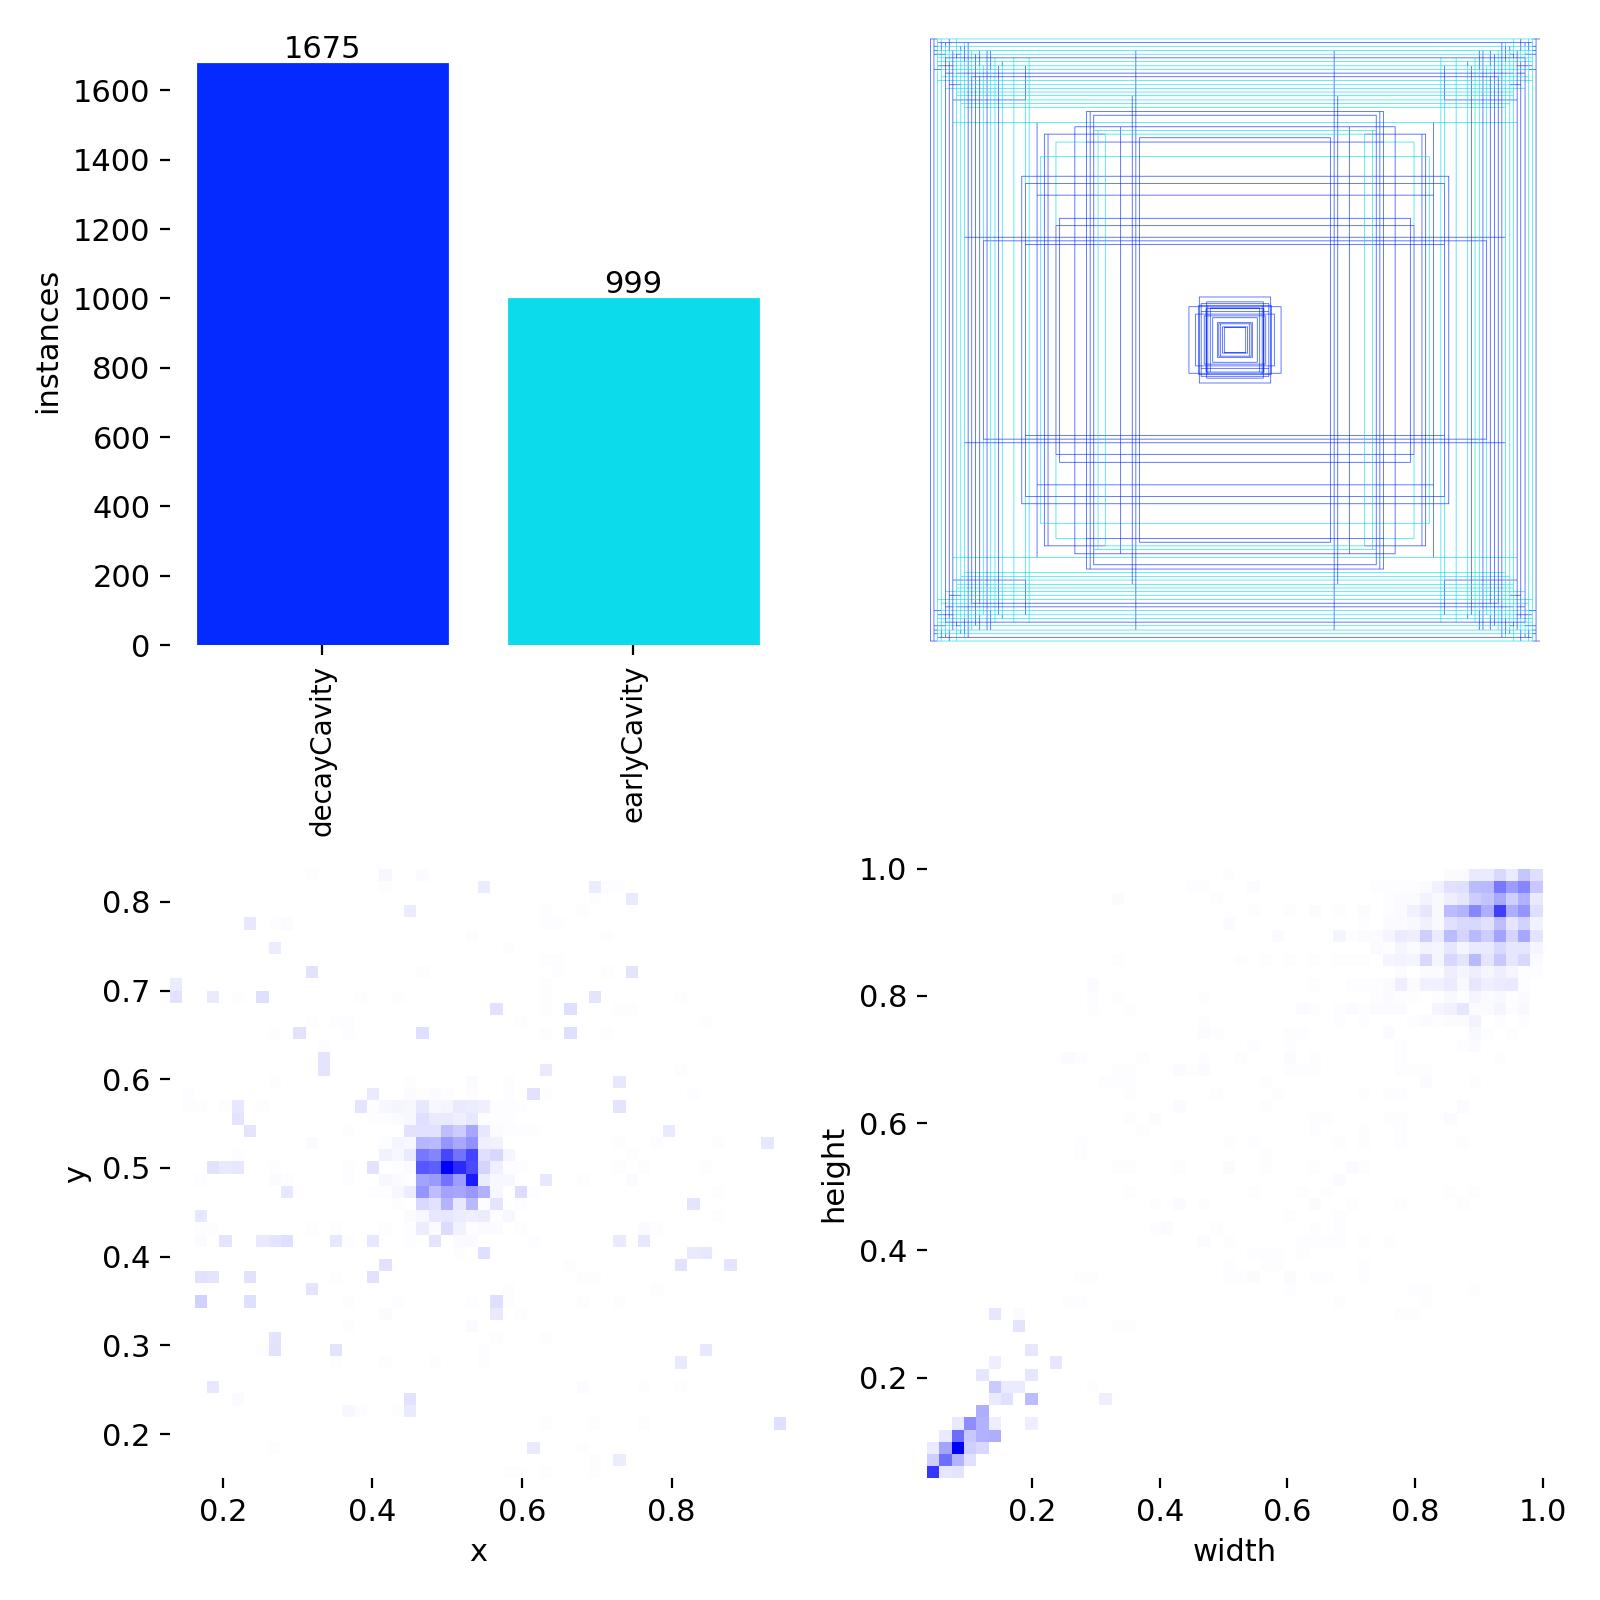

labels_correlogram.jpg not found in latest run folder


In [ ]:
import os
import pandas as pd
from IPython.display import display, Image, display_png
import matplotlib.pyplot as plt

# --- 1️⃣ Find latest run folder ---
base_run_folder = "/content/runs/detect"  # YOLO default
subfolders = [os.path.join(base_run_folder, f) for f in os.listdir(base_run_folder)]
subfolders = [f for f in subfolders if os.path.isdir(f)]
latest_run = max(subfolders, key=os.path.getmtime)
print("Latest run folder:", latest_run)

# --- 2️⃣ Show results.csv metrics ---
results_csv = os.path.join(latest_run, "results.csv")
if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
    print("Training metrics per epoch:")
    display(df)
else:
    print("results.csv not found!")

# --- 3️⃣ Display evaluation images ---
eval_images = [
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
    "PR_curve.png",
    "F1_curve.png",
    "R_curve.png",
    "P_curve.png",
    "labels.jpg",
    "labels_correlogram.jpg"
]

for img_name in eval_images:
    img_path = os.path.join(latest_run, img_name)
    if os.path.exists(img_path):
        display(Image(filename=img_path))
    else:
        print(img_name, "not found in latest run folder")


Using model: /content/runs/detect/combined_train/weights/best.pt


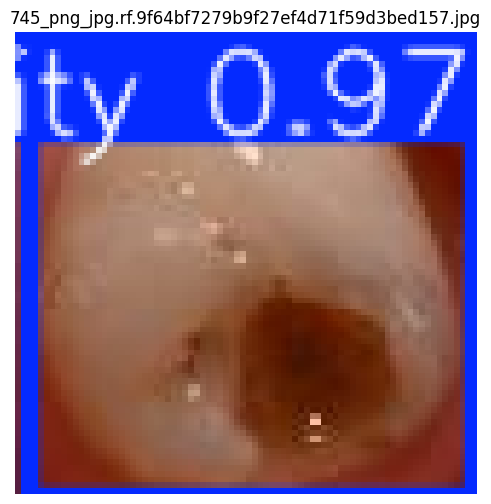

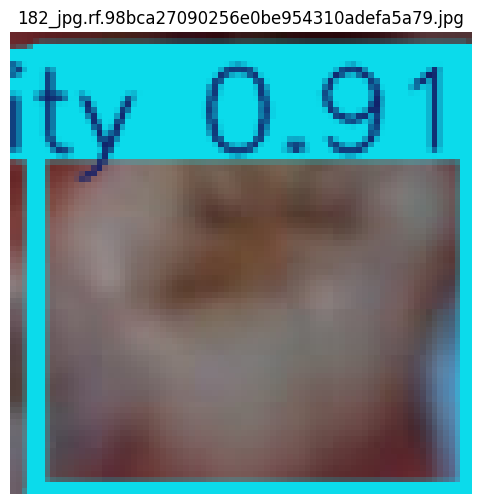

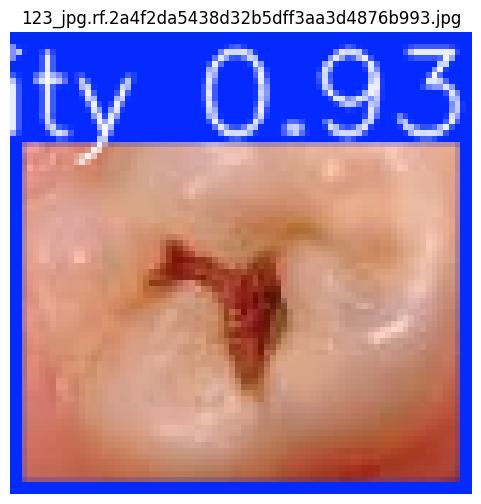

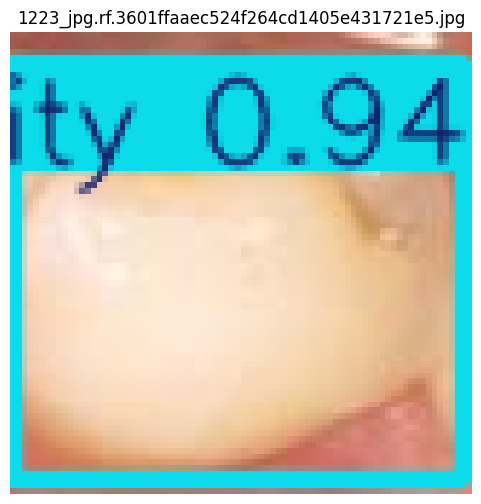

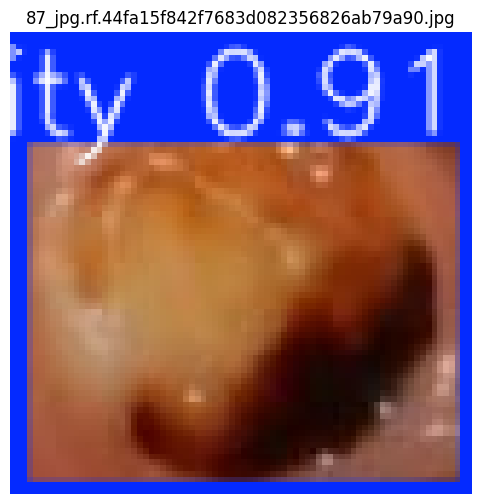

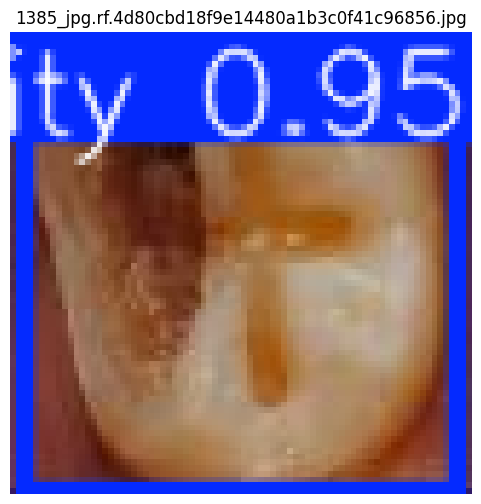

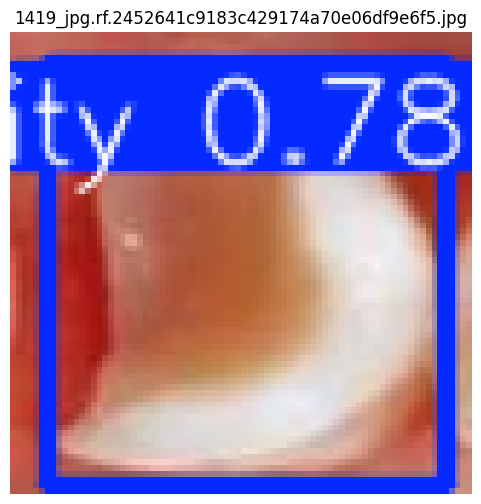

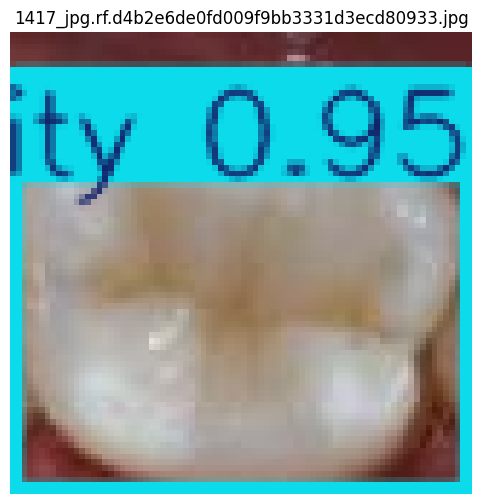

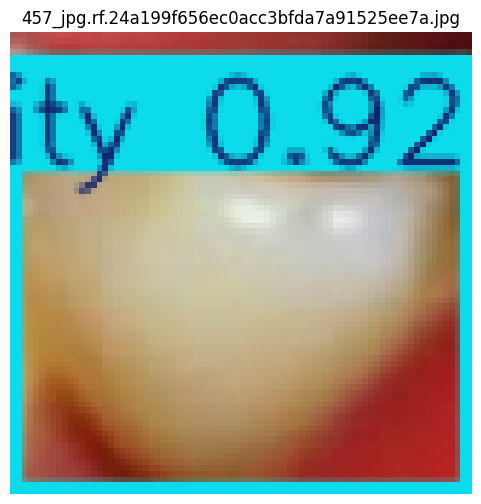

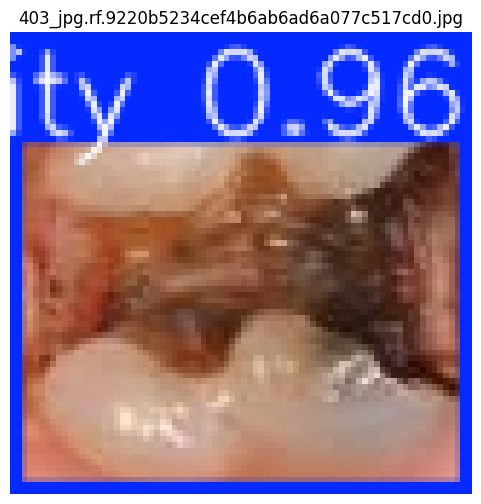

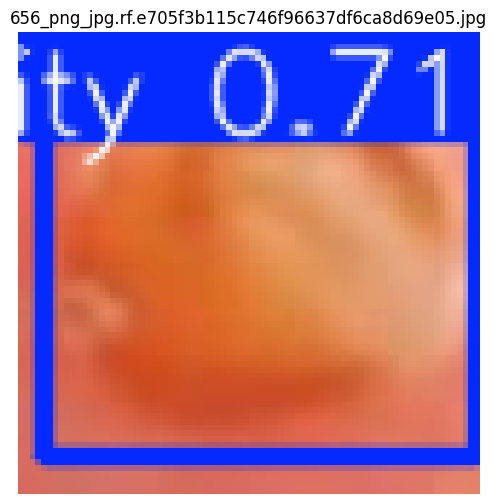

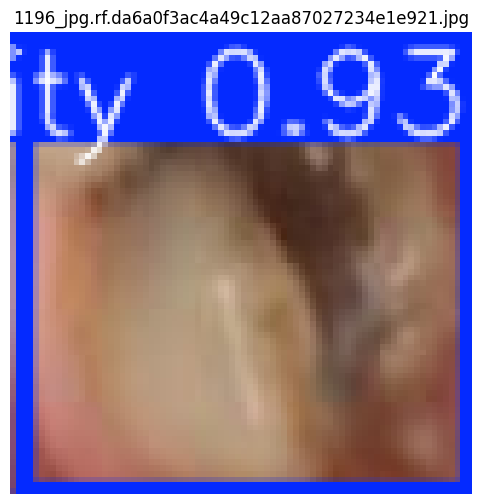

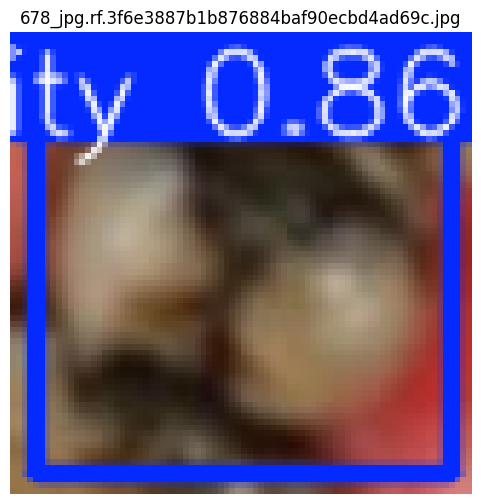

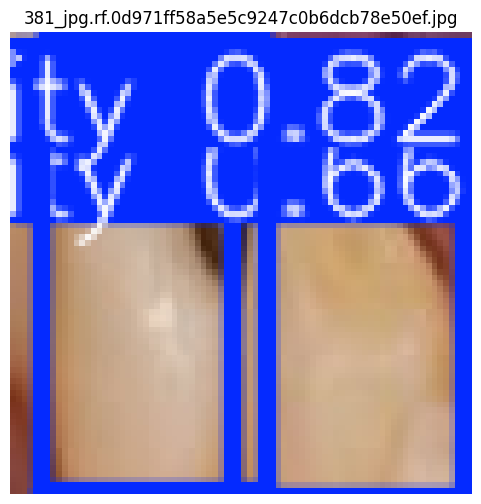

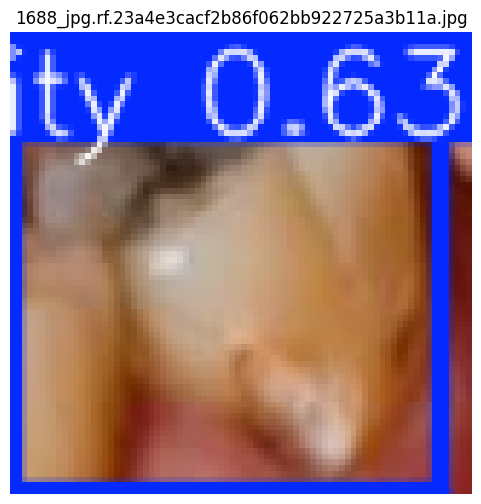

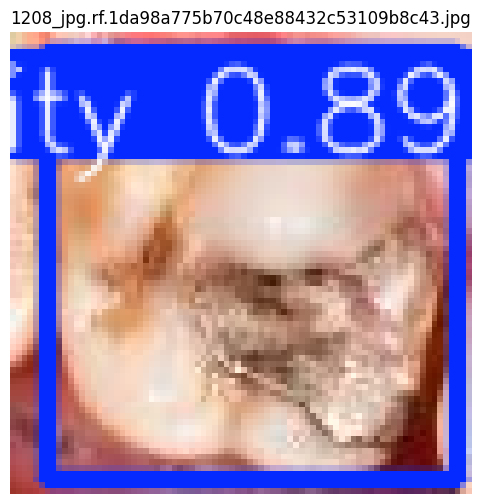

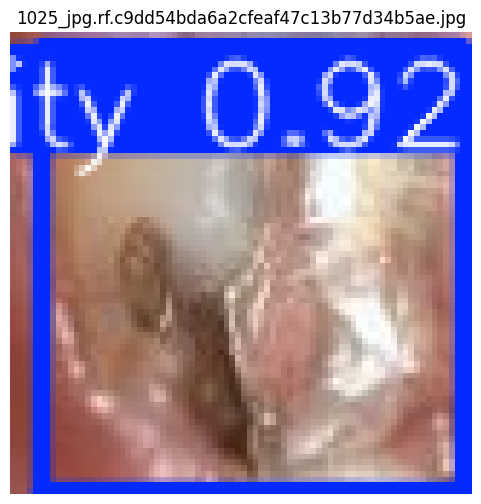

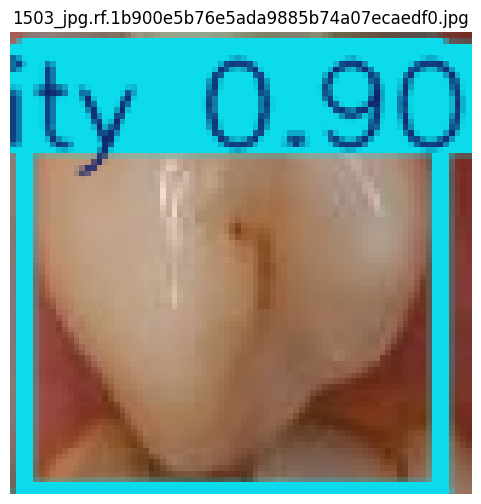

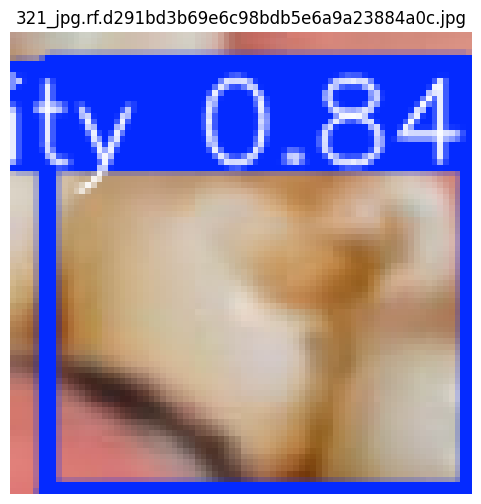

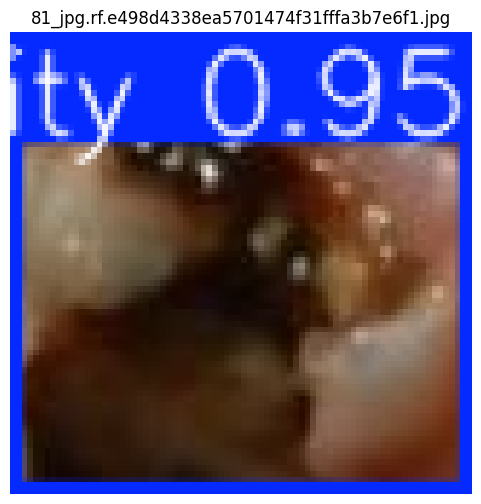

In [ ]:
# --- 1️⃣ Imports ---
import os
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, Image, display_png
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- 2️⃣ Paths ---
run_folder = "/content/runs/detect"  # YOLO default
latest_run = max([os.path.join(run_folder,f) for f in os.listdir(run_folder) if os.path.isdir(os.path.join(run_folder,f))],
                 key=os.path.getmtime)

model_path = os.path.join(latest_run, "weights", "best.pt")
print("Using model:", model_path)

# --- 3️⃣ Load model ---
model = YOLO(model_path)

# --- 4️⃣ Load validation dataset ---
val_images_path = "/content/2classes-real-with-augmentation-3/valid/images"  # adjust to your single-tooth dataset
val_labels_path = "/content/2classes-real-with-augmentation-3/valid/labels"

val_images = [f for f in os.listdir(val_images_path) if f.endswith(('.jpg','.png','.jpeg'))]
sample_images = random.sample(val_images, min(20, len(val_images)))  # take 20 random images

all_true = []
all_pred = []

names = model.names

# --- 5️⃣ Run predictions and collect labels ---
for img_file in sample_images:
    img_path = os.path.join(val_images_path, img_file)
    label_file = os.path.join(val_labels_path, img_file.replace(".jpg",".txt").replace(".png",".txt"))

    # Ground truth labels
    true_labels = []
    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            for line in f:
                cls = int(line.split()[0])
                true_labels.append(cls)

    results = model.predict(img_path, conf=0.25, verbose=False)

    # Predicted labels (for each box above conf threshold)
    pred_labels = results[0].boxes.cls.cpu().numpy().astype(int) if results[0].boxes is not None else []

    all_true.extend(true_labels)
    all_pred.extend(pred_labels)

    # Optional: show image with predicted boxes
    output_img = results[0].plot()
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.title(img_file)
    plt.axis('off')
    plt.show()




In [ ]:
from google.colab import files

# Download the combined dataset model
files.download("/content/runs/detect/combined_train/weights/best.pt")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>